# 朴素贝叶斯 (Naive Bayes)

## 📚 本节目标
- 理解贝叶斯定理和朴素贝叶斯假设
- 掌握三种常见的朴素贝叶斯分类器
- 学习文本分类应用
- 从零实现朴素贝叶斯
- 使用Scikit-learn的朴素贝叶斯模型
- 理解朴素贝叶斯的优缺点

---

## 1️⃣ 贝叶斯定理

### 贝叶斯公式
$$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$$

其中：
- $P(y|X)$: **后验概率** - 给定特征X，样本属于类别y的概率
- $P(X|y)$: **似然** - 类别y下观察到特征X的概率
- $P(y)$: **先验概率** - 类别y的概率
- $P(X)$: **证据** - 观察到特征X的概率

### 朴素贝叶斯假设
**"朴素"**：假设特征之间相互独立

$$P(X|y) = P(x_1|y) \cdot P(x_2|y) \cdot ... \cdot P(x_n|y)$$

虽然这个假设在现实中很少成立，但朴素贝叶斯在实践中效果出奇地好！

### 分类决策
选择后验概率最大的类别：
$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i|y)$$

### 三种常见的朴素贝叶斯
1. **高斯朴素贝叶斯** (GaussianNB)
   - 特征服从正态分布
   - 适用于连续特征

2. **多项式朴素贝叶斯** (MultinomialNB)
   - 特征为离散计数
   - 适用于文本分类（词频）

3. **伯努利朴素贝叶斯** (BernoulliNB)
   - 特征为二元（0/1）
   - 适用于文本分类（词是否出现）

---

## 📦 导入库

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# sklearn相关
from sklearn.datasets import load_iris, make_classification, fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# 文本处理
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

np.random.seed(42)

## 2️⃣ 从零实现高斯朴素贝叶斯

In [19]:
class GaussianNaiveBayes:
    """从零实现的高斯朴素贝叶斯分类器"""
    
    def __init__(self):
        self.classes = None
        self.priors = {}  # 先验概率 P(y)
        self.means = {}   # 每个类别每个特征的均值
        self.stds = {}    # 每个类别每个特征的标准差
    
    def fit(self, X, y):
        """训练模型"""
        self.classes = np.unique(y)
        n_samples = len(y)
        
        for c in self.classes:
            # 获取类别c的所有样本
            X_c = X[y == c]
            
            # 计算先验概率 P(y=c)
            self.priors[c] = len(X_c) / n_samples
            
            # 计算每个特征的均值和标准差
            self.means[c] = X_c.mean(axis=0)
            self.stds[c] = X_c.std(axis=0) + 1e-9  # 避免除零
        
        return self
    
    def _gaussian_probability(self, x, mean, std):
        """计算高斯概率密度"""
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return exponent / (np.sqrt(2 * np.pi) * std)
    
    def _predict_single(self, x):
        """预测单个样本"""
        posteriors = []
        
        for c in self.classes:
            # 先验概率 P(y=c)
            prior = np.log(self.priors[c])
            
            # 似然 P(X|y=c) = P(x1|y=c) * P(x2|y=c) * ...
            # 使用log避免数值下溢
            likelihood = np.sum(
                np.log(self._gaussian_probability(x, self.means[c], self.stds[c]))
            )
            
            # 后验概率 P(y=c|X) ∝ P(X|y=c) * P(y=c)
            posterior = prior + likelihood
            posteriors.append(posterior)
        
        # 返回后验概率最大的类别
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        """预测多个样本"""
        return np.array([self._predict_single(x) for x in X])
    
    def score(self, X, y):
        """计算准确率"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

### 测试自定义高斯朴素贝叶斯

# 加载iris数据集
iris = load_iris()
X = iris.data
y = iris.target

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练自定义模型
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

# 评估
train_score = gnb.score(X_train, y_train)
test_score = gnb.score(X_test, y_test)

print("自定义高斯朴素贝叶斯：")
print(f"训练集准确率: {train_score:.4f}")
print(f"测试集准确率: {test_score:.4f}")

# 对比sklearn的实现
sklearn_gnb = GaussianNB()
sklearn_gnb.fit(X_train, y_train)
sklearn_score = sklearn_gnb.score(X_test, y_test)

print(f"\nSklearn高斯朴素贝叶斯准确率: {sklearn_score:.4f}")

## 3️⃣ 高斯朴素贝叶斯详解

### 3.1 基本使用

# 生成二分类数据
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练模型
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 预测
y_pred = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)  # 预测概率

# 评估
print("高斯朴素贝叶斯性能：")
print("=" * 50)
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred))

# 查看学到的参数
print("\n学到的参数：")
print(f"类先验概率: {gnb.class_prior_}")
print(f"\n类别0的特征均值: {gnb.theta_[0]}")
print(f"类别1的特征均值: {gnb.theta_[1]}")

### 3.2 决策边界可视化

In [ ]:
def plot_decision_boundary(model, X, y, title="决策边界"):
    """绘制决策边界和概率"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, levels=20, alpha=0.6, cmap='RdYlBu_r')
    plt.colorbar(label='类别1的概率')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu_r', 
                edgecolors='black', s=50, alpha=0.8)
    plt.xlabel('特征 1')
    plt.ylabel('特征 2')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(gnb, X_train, y_train, "高斯朴素贝叶斯决策边界")

## 4️⃣ 文本分类：多项式和伯努利朴素贝叶斯

### 4.1 简单文本分类示例

In [ ]:
# 示例文本数据
texts = [
    "机器学习很有趣",
    "深度学习是机器学习的一部分",
    "我喜欢学习Python",
    "今天天气很好",
    "我喜欢晴天",
    "明天会下雨吗",
    "神经网络很强大",
    "卷积神经网络用于图像处理",
]

# 标签：0表示技术类，1表示天气类
labels = [0, 0, 0, 1, 1, 1, 0, 0]

# 文本向量化
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(texts)

print("词汇表：")
print(vectorizer.get_feature_names_out())
print(f"\n特征矩阵形状: {X_text.shape}")
print("\n特征矩阵（词频）：")
print(X_text.toarray())

### 4.2 多项式朴素贝叶斯

In [ ]:
# 训练多项式朴素贝叶斯
mnb = MultinomialNB()
mnb.fit(X_text, labels)

# 测试
test_texts = [
    "学习机器学习",
    "天气预报",
    "神经网络学习"
]

X_test_text = vectorizer.transform(test_texts)
predictions = mnb.predict(X_test_text)
probabilities = mnb.predict_proba(X_test_text)

print("多项式朴素贝叶斯预测：")
print("=" * 60)
for text, pred, proba in zip(test_texts, predictions, probabilities):
    category = "技术" if pred == 0 else "天气"
    print(f"文本: '{text}'")
    print(f"预测类别: {category}")
    print(f"概率: 技术={proba[0]:.3f}, 天气={proba[1]:.3f}")
    print("-" * 60)

### 4.3 伯努利朴素贝叶斯

In [ ]:
# 伯努利朴素贝叶斯（关注词是否出现，而非频率）
bnb = BernoulliNB()
# 需要将计数转为二值
X_binary = (X_text > 0).astype(int)
bnb.fit(X_binary, labels)

# 预测
X_test_binary = (X_test_text > 0).astype(int)
predictions_bnb = bnb.predict(X_test_binary)
probabilities_bnb = bnb.predict_proba(X_test_binary)

print("伯努利朴素贝叶斯预测：")
print("=" * 60)
for text, pred, proba in zip(test_texts, predictions_bnb, probabilities_bnb):
    category = "技术" if pred == 0 else "天气"
    print(f"文本: '{text}'")
    print(f"预测类别: {category}")
    print(f"概率: 技术={proba[0]:.3f}, 天气={proba[1]:.3f}")
    print("-" * 60)

## 5️⃣ 实战：新闻分类

使用20 Newsgroups数据集进行多类别文本分类

In [29]:
# 加载部分类别的新闻数据（使用本地缓存）
import pickle
from pathlib import Path

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# 从本地缓存加载数据
data_home = Path("/Users/lyh/scikit_learn_data/20news_home")

# 加载训练集
with open(data_home / "20news-bydate_py3.pkz", 'rb') as f:
    train_data_all = pickle.load(f)

# 加载测试集
with open(data_home / "20news-bydate-test_py3.pkz", 'rb') as f:
    test_data_all = pickle.load(f)

# 筛选指定类别
def filter_categories(data, categories):
    """筛选指定类别的数据"""
    # 获取类别索引
    category_indices = [i for i, name in enumerate(data['target_names']) if name in categories]
    category_map = {old_idx: new_idx for new_idx, old_idx in enumerate(category_indices)}
    
    # 筛选数据
    filtered_data = []
    filtered_target = []
    for text, label in zip(data['data'], data['target']):
        if label in category_indices:
            filtered_data.append(text)
            filtered_target.append(category_map[label])
    
    return {
        'data': filtered_data,
        'target': np.array(filtered_target),
        'target_names': [data['target_names'][i] for i in category_indices]
    }

newsgroups_train = filter_categories(train_data_all, categories)
newsgroups_test = filter_categories(test_data_all, categories)

print(f"训练样本数: {len(newsgroups_train['data'])}")
print(f"测试样本数: {len(newsgroups_test['data'])}")
print(f"类别: {newsgroups_train['target_names']}")

# 查看示例
print("\n示例文本：")
print(newsgroups_train['data'][0][:200] + "...")
print(f"类别: {newsgroups_train['target_names'][newsgroups_train['target'][0]]}")

训练样本数: 2034
测试样本数: 1353
类别: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

示例文本：
From: "Robert Knowles" <p00261@psilink.com>
Subject: Re: KORESH IS GOD!
In-Reply-To: <930416.141520.7h1.rusnews.w165w@mantis.co.uk>
Nntp-Posting-Host: 127.0.0.1
Organization: Kupajava, East of Krakato...
类别: alt.atheism


### 文本向量化和模型训练

In [17]:
# TF-IDF向量化
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(newsgroups_train['data'])
X_test_tfidf = tfidf_vectorizer.transform(newsgroups_test['data'])

print(f"TF-IDF特征矩阵形状: {X_train_tfidf.shape}")

# 训练多项式朴素贝叶斯
mnb_news = MultinomialNB(alpha=0.1)  # alpha是平滑参数
mnb_news.fit(X_train_tfidf, newsgroups_train['target'])

# 预测
y_pred = mnb_news.predict(X_test_tfidf)

# 评估
print("\n新闻分类性能：")
print("=" * 60)
print(f"准确率: {accuracy_score(newsgroups_test['target'], y_pred):.4f}")
print("\n分类报告：")
print(classification_report(
    newsgroups_test['target'], 
    y_pred, 
    target_names=newsgroups_test['target_names']
))

TF-IDF特征矩阵形状: (2034, 5000)

新闻分类性能：
准确率: 0.8928

分类报告：
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.85      0.85       319
     comp.graphics       0.93      0.96      0.95       389
         sci.space       0.93      0.95      0.94       394
talk.religion.misc       0.83      0.76      0.79       251

          accuracy                           0.89      1353
         macro avg       0.88      0.88      0.88      1353
      weighted avg       0.89      0.89      0.89      1353



### 混淆矩阵可视化

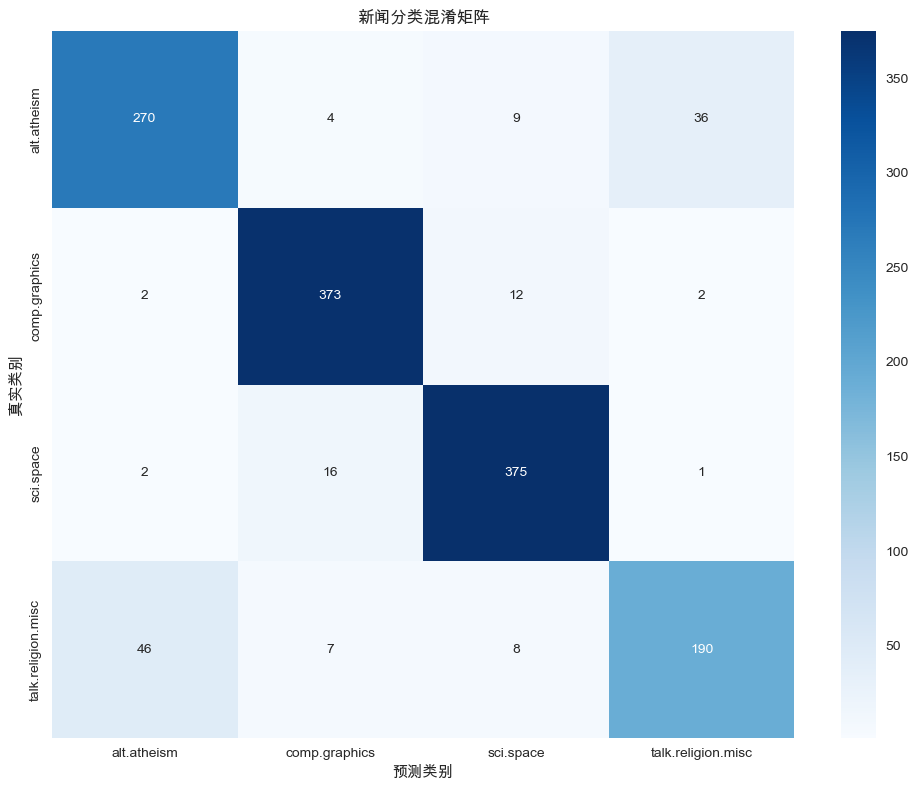

In [30]:
# 混淆矩阵
cm = confusion_matrix(newsgroups_test['target'], y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=newsgroups_test['target_names'],
            yticklabels=newsgroups_test['target_names'])
plt.xlabel('预测类别')
plt.ylabel('真实类别')
plt.title('新闻分类混淆矩阵')
plt.tight_layout()
plt.show()

### 特征重要性分析

In [31]:
# 获取每个类别最重要的词
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10

print("每个类别的Top关键词：")
print("=" * 60)

for i, category in enumerate(newsgroups_test['target_names']):
    # 获取该类别的log概率
    top_indices = mnb_news.feature_log_prob_[i].argsort()[-n_top_words:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    
    print(f"\n{category}:")
    print(", ".join(top_words))

每个类别的Top关键词：

alt.atheism:
edu, keith, god, com, caltech, people, writes, atheists, livesey, sgi

comp.graphics:
graphics, edu, lines, university, subject, com, thanks, organization, files, image

sci.space:
space, edu, nasa, henry, access, com, alaska, gov, moon, toronto

talk.religion.misc:
god, com, edu, sandvik, jesus, christian, people, writes, kent, article


## 6️⃣ 三种朴素贝叶斯对比


三种朴素贝叶斯对比：
            模型      准确率
    多项式NB (词频) 0.898004
多项式NB (TF-IDF) 0.885440
         伯努利NB 0.826312


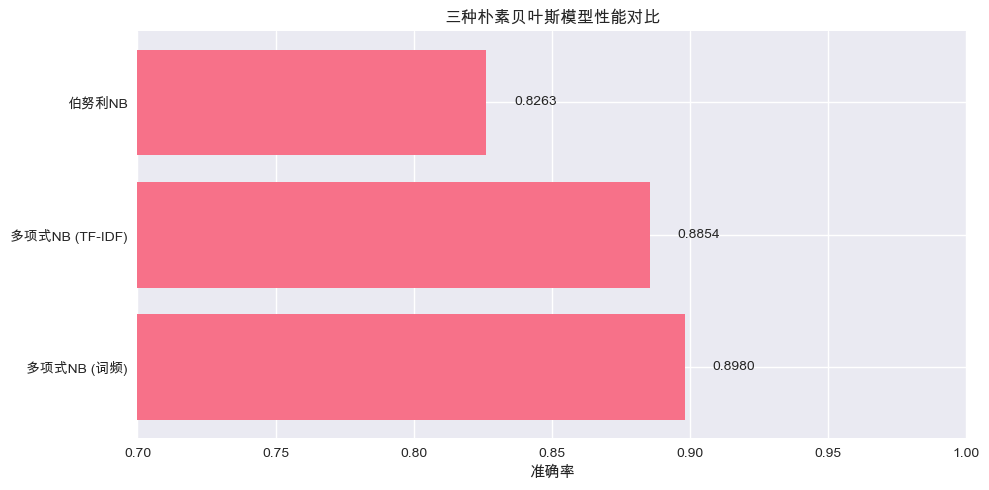

In [32]:
# 使用CountVectorizer（词频）
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train_count = count_vectorizer.fit_transform(newsgroups_train['data'])
X_test_count = count_vectorizer.transform(newsgroups_test['data'])

# 二值化
X_train_binary = (X_train_count > 0).astype(int)
X_test_binary = (X_test_count > 0).astype(int)

# 训练三种模型
models = {
    '多项式NB (词频)': MultinomialNB().fit(X_train_count, newsgroups_train['target']),
    '多项式NB (TF-IDF)': MultinomialNB().fit(X_train_tfidf, newsgroups_train['target']),
    '伯努利NB': BernoulliNB().fit(X_train_binary, newsgroups_train['target']),
}

# 评估
results = []
for name, model in models.items():
    if 'TF-IDF' in name:
        X_test_use = X_test_tfidf
    elif '伯努利' in name:
        X_test_use = X_test_binary
    else:
        X_test_use = X_test_count
    
    y_pred = model.predict(X_test_use)
    accuracy = accuracy_score(newsgroups_test['target'], y_pred)
    
    results.append({
        '模型': name,
        '准确率': accuracy
    })

# 显示结果
results_df = pd.DataFrame(results)
print("\n三种朴素贝叶斯对比：")
print(results_df.to_string(index=False))

# 可视化
plt.figure(figsize=(10, 5))
plt.barh(results_df['模型'], results_df['准确率'])
plt.xlabel('准确率')
plt.title('三种朴素贝叶斯模型性能对比')
plt.xlim(0.7, 1.0)
for i, v in enumerate(results_df['准确率']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

## 7️⃣ 平滑参数调优

平滑参数(alpha)用于处理训练集中未出现的特征

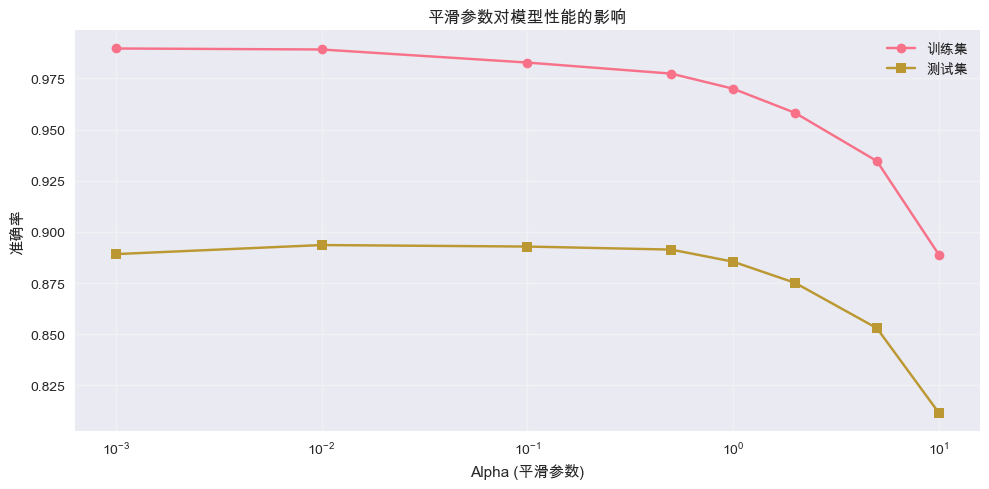


最优alpha: 0.01
最高测试准确率: 0.8936


In [33]:
# 测试不同的alpha值
alphas = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
train_scores = []
test_scores = []

for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train_tfidf, newsgroups_train['target'])
    
    train_scores.append(mnb.score(X_train_tfidf, newsgroups_train['target']))
    test_scores.append(mnb.score(X_test_tfidf, newsgroups_test['target']))

# 可视化
plt.figure(figsize=(10, 5))
plt.plot(alphas, train_scores, marker='o', label='训练集')
plt.plot(alphas, test_scores, marker='s', label='测试集')
plt.xscale('log')
plt.xlabel('Alpha (平滑参数)')
plt.ylabel('准确率')
plt.title('平滑参数对模型性能的影响')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_alpha = alphas[np.argmax(test_scores)]
print(f"\n最优alpha: {best_alpha}")
print(f"最高测试准确率: {max(test_scores):.4f}")

## 8️⃣ 网格搜索优化

In [ ]:
# 参数网格
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]  # 是否学习类先验概率
}

# 网格搜索
grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, newsgroups_train['target'])

print("\n最优参数：")
print(grid_search.best_params_)
print(f"\n最优交叉验证准确率: {grid_search.best_score_:.4f}")

# 测试集评估
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_tfidf, newsgroups_test['target'])
print(f"测试集准确率: {test_score:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


## 9️⃣ 朴素贝叶斯的优缺点

### ✅ 优点
1. **简单高效**
   - 训练和预测速度快
   - 内存占用小
   
2. **适合高维数据**
   - 特别适合文本分类
   - 不易过拟合
   
3. **可解释性强**
   - 基于概率论，结果易理解
   - 可以查看特征重要性
   
4. **少量数据也能工作**
   - 对小样本友好
   
5. **多分类天然支持**
   - 不需要one-vs-rest策略

### ❌ 缺点
1. **特征独立性假设**
   - 现实中特征往往相关
   - 但实践中影响不大
   
2. **对特征分布敏感**
   - 需要选择合适的朴素贝叶斯类型
   - 高斯NB要求特征近似正态分布
   
3. **零概率问题**
   - 需要平滑技术（Laplace平滑）
   
4. **不适合回归问题**
   - 主要用于分类

### 使用场景
✅ **适合：**
- 文本分类（垃圾邮件过滤、情感分析）
- 实时预测（速度要求高）
- 多分类问题
- 高维稀疏数据
- 作为baseline模型

❌ **不适合：**
- 特征高度相关的数据
- 需要精确概率估计的场景
- 回归问题

---

## 📊 总结

### 关键要点
1. **贝叶斯定理**：后验 = (似然 × 先验) / 证据
2. **朴素假设**：特征条件独立
3. **三种类型**：
   - 高斯NB：连续特征
   - 多项式NB：离散计数（词频）
   - 伯努利NB：二值特征（词出现）
4. **平滑技术**：防止零概率
5. **文本分类王者**：速度快，效果好

### 实践建议
1. **数据类型决定NB类型**
   - 连续 → 高斯NB
   - 计数 → 多项式NB
   - 二值 → 伯努利NB

2. **调优重点**
   - 平滑参数alpha
   - 文本向量化方法（词频 vs TF-IDF）
   - 特征数量

3. **性能优化**
   - 特征选择
   - 停用词处理
   - N-gram特征

---

## 💡 练习题

1. **基础练习**：使用高斯朴素贝叶斯在iris数据集上实验，对比不同先验设置的效果

2. **文本分类**：构建一个垃圾邮件分类器，对比三种朴素贝叶斯的性能

3. **进阶练习**：实现带拉普拉斯平滑的多项式朴素贝叶斯

4. **挑战练习**：在IMDB电影评论数据集上进行情感分析，优化至准确率>85%

下一节：[05_logistic_regression.ipynb](05_logistic_regression.ipynb) - 逻辑回归